In [1]:
import os
import pandas as pd
import numpy as np
import time
import pickle
import random
random.seed(0)

import matplotlib.pyplot as plt

import lightgbm as lgb
import gc

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
from process import type_score

In [4]:
DATA_DATE = '20190721'
MODEL_DATE = '20190808'

In [5]:
# input files
features_train = OUTPUT + DATA_DATE + '_' + 'dist_ang_ori_bond_cos_train_{}.pickle'
features_test = OUTPUT + DATA_DATE + '_' + 'dist_ang_ori_bond_cos_test_{}.pickle'

In [6]:
# output files
trained_models =  OUTPUT + MODEL_DATE + '_' + 'champs_models_lgb_{}.pickle'

pred_train_temp = OUTPUT + 'predict_train_temp_{}.pickle'
mols_split = OUTPUT + MODEL_DATE + '_' + 'molecule_name_split.pickle'

pred_train = OUTPUT + MODEL_DATE  + '_' + 'pred_train_0.pickle'

pred_test = OUTPUT + MODEL_DATE  + '_' + 'submission_0.csv'

submission_temp = OUTPUT + 'submission_temp_{}.pickle'

In [25]:
df = pd.DataFrame()
bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']
for b in bond_types:
    df_bond = pd.read_pickle(features_test.format(b)).fillna(0)
    df = pd.concat([df, df_bond], axis=0)

In [28]:
df.isnull().sum().sort_values()

id                          0
orientation_H_4_y           0
orientation_H_5_y           0
orientation_H_6_y           0
orientation_H_7_y           0
orientation_H_8_y           0
orientation_H_9_y           0
orientation_H_10_y          0
orientation_H_11_y          0
dist_C_0_y                  0
dist_C_1_y                  0
dist_C_2_y                  0
dist_C_3_y                  0
dist_C_4_y                  0
dist_C_5_y                  0
dist_C_6_y                  0
dist_C_7_y                  0
angle_C_0_y                 0
angle_C_1_y                 0
angle_C_2_y                 0
angle_C_3_y                 0
angle_C_4_y                 0
angle_C_5_y                 0
angle_C_6_y                 0
orientation_H_3_y           0
angle_C_7_y                 0
orientation_H_2_y           0
angle_H_11_y                0
dist_H_0_y                  0
dist_H_1_y                  0
                       ...   
dist_N_0_x                  0
orientation_C_1_x           0
orientatio

In [9]:
mols = df['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.9)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [ ]:
mols_train = mols[pick_train]
mols_val = mols[pick_val]

In [ ]:
df_train = df[df['molecule_name'].isin(mols_train)]
df_val = df[df['molecule_name'].isin(mols_val)]

In [ ]:
with open(mols_split, 'wb') as f:
    pickle.dump(mols_train, f)
    pickle.dump(mols_val, f)

In [ ]:
rounds = 300000
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l1'},
        'num_leaves' : 63,
        'learning_rate' : 0.005,
        'feature_fraction' : 0.8,
    'seed':0
}
bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']

---------- 3JHN ----------
99678
score train: -4.27
score valid: -2.23


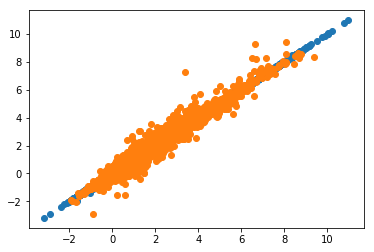

---------- 3JHC ----------
300000
score train: -2.27
score valid: -1.41


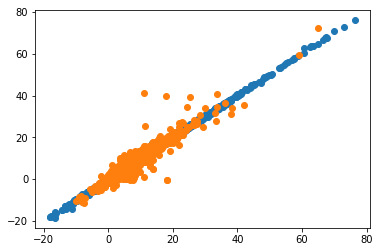

---------- 1JHC ----------
296154
score train: -2.33
score valid: -0.78


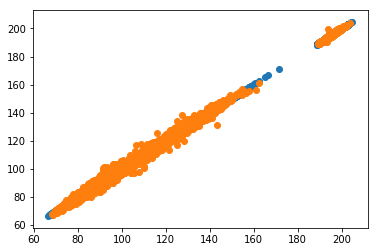

---------- 2JHH ----------
186766
score train: -3.98
score valid: -2.13


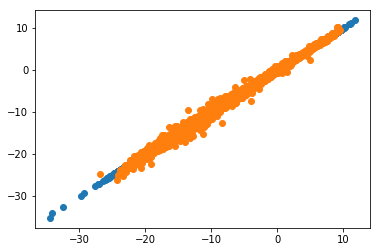

---------- 1JHN ----------
31993
score train: -3.47
score valid: -1.35


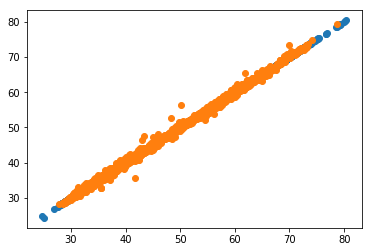

---------- 2JHN ----------
60889
score train: -3.71
score valid: -1.97


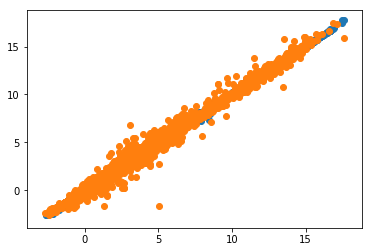

---------- 2JHC ----------
300000
score train: -2.63
score valid: -1.54


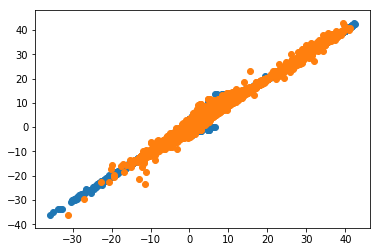

---------- 3JHH ----------
284222
score train: -3.93
score valid: -2.11


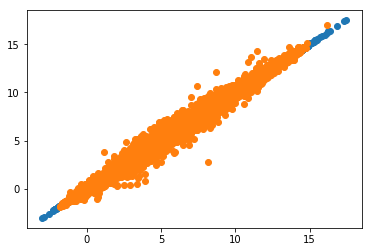

total elapsed_time:28.52[hours]


In [ ]:
scores = []
start0 = time.time()

for i, b in enumerate(bond_types):
    print('-'*10, b, '-'*10)
    
    y_train_pred_b =[]
    y_val_pred_b =[]
    
    df_train_b = df_train.query('type == "{}"'.format(b))
    y_train = df_train_b['scalar_coupling_constant'].values
    X_train = df_train_b[df_train_b.columns[6:]].values

    df_val_b = df_val.query('type == "{}"'.format(b))
    y_val = df_val_b['scalar_coupling_constant'].values
    X_val = df_val_b[df_val_b.columns[6:]].values

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=rounds,
                verbose_eval=0,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

    y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
    df_train_pred_b = pd.DataFrame([df_train_b['id'], y_train_pred], index=['id', 'scalar_coupling_constant']).T
    
    y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    df_val_pred_b = pd.DataFrame([df_val_b['id'], y_val_pred], index=['id', 'scalar_coupling_constant']).T
    
    df_pred_b = pd.concat([df_train_pred_b, df_val_pred_b], axis=0)
    df_pred_b.to_pickle(pred_train_temp.format(b))
    
    score_train = type_score(y_train_pred, y_train)
    score_val = type_score(y_val_pred, y_val)
    
    print(gbm.best_iteration)
    print('score train: %.2f' % score_train)
    print('score valid: %.2f' % score_val)
    
    plt.scatter(y_train_pred, y_train)
    plt.scatter(y_val_pred, y_val)
    plt.show()
    
    with open(trained_models.format(b), 'wb') as f:
        pickle.dump(gbm, f)

    scores.append(score_val)
    gc.collect()
elapsed_time = time.time() - start0
print ("total elapsed_time:%.2f" % (elapsed_time/3600) + "[hours]")


In [ ]:
print('type score:', scores)
print('total score:', np.array(scores).mean())

# bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']
# type score: [-2.213330811075121, -1.3581258350105094, -0.7845050130296711, -2.1655013094988513, -1.4024121799402647, -1.9751865470643377, -1.499394936229838, -2.1188348800106724]
# total score: -1.689661438982408

# type score: [-2.226743610048564, -1.409414866258736, -0.7786536175446308, -2.1293185234551006, -1.3491208855275625, -1.973349148953741, -1.540499443927113, -2.1123116402385937]
# total score: -1.689926466994255


type score: [-2.226743610048564, -1.409414866258736, -0.7786536175446308, -2.1293185234551006, -1.3491208855275625, -1.973349148953741, -1.540499443927113, -2.1123116402385937]
total score: -1.689926466994255


In [13]:
df_train_predict = pd.DataFrame()

for b in bond_types:
    df_train_predict_b = pd.read_pickle(pred_train_temp.format(b))
    df_train_predict = pd.concat([df_train_predict, df_train_predict_b], axis=0)
    
df_train_predict.to_pickle(pred_train)

In [29]:
for b in bond_types:
    print('-'*10, b, '-'*10)
    start = time.time()
    df_bond = pd.read_pickle(features_test.format(b)).fillna(0)
    y_pred_b =[]

    with open(trained_models.format(b), 'rb') as f:
        gbm = pickle.load(f)

    X_test = df_bond[df_bond.columns[5:]].values  
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    df_submit_b = pd.DataFrame([df_bond['id'], y_pred], index=['id', 'scalar_coupling_constant']).T
    df_submit_b.to_pickle(submission_temp.format(b))
    
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    gc.collect()

---------- 3JHN ----------
elapsed_time:127.03887128829956[sec]
---------- 3JHC ----------
elapsed_time:3017.8215959072113[sec]
---------- 1JHC ----------
elapsed_time:1508.715755224228[sec]
---------- 2JHH ----------
elapsed_time:538.2185151576996[sec]
---------- 1JHN ----------
elapsed_time:14.471306562423706[sec]
---------- 2JHN ----------
elapsed_time:61.874218702316284[sec]
---------- 2JHC ----------
elapsed_time:2324.936847448349[sec]
---------- 3JHH ----------
elapsed_time:1041.7235836982727[sec]


In [30]:
df_submit = pd.DataFrame()
for b in bond_types:
    df_submit_b = pd.read_pickle(submission_temp.format(b))
    df_submit = pd.concat([df_submit, df_submit_b], axis=0)
    
df_submit['id'] = df_submit['id'].astype('int32')
df_submit.head()

,id,scalar_coupling_constant
0,4658205,0.105479
1,4658209,2.455921
2,4658210,0.105479
3,4658214,2.455367
4,4658555,-0.520978


In [31]:
df_submit.to_csv(pred_test, index=False)

In [32]:
for b in bond_types:
    print('-'*10, b, '-'*10)
    start = time.time()
    df = pd.read_pickle(features_train.format(b)).fillna(0)

    with open(trained_models.format(b), 'rb') as f:
        gbm = pickle.load(f)

    X = df[df.columns[6:]].values  
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    
    df_pred = pd.DataFrame([df['id'], y_pred], index=['id', 'scalar_coupling_constant']).T
    df_pred['id'] = df_pred['id'].astype('int32')
    df_pred.to_pickle(pred_train_temp.format(b))
    
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    gc.collect()
    
df_pred_train = pd.DataFrame()
for b in bond_types:
    df_b = pd.read_pickle(pred_train_temp.format(b))
    df_pred_train = pd.concat([df_pred_train, df_b], axis=0, sort=False)
    
df_pred_train['id'] = df_pred_train['id'].astype('int32')
df_pred_train = df_pred_train.reset_index(drop=True)
df_pred_train.head()

df_pred_train.to_pickle(pred_train)

---------- 3JHN ----------
elapsed_time:211.14290475845337[sec]
---------- 3JHC ----------
elapsed_time:5195.828676223755[sec]
---------- 1JHC ----------
elapsed_time:2504.3042948246[sec]
---------- 2JHH ----------
elapsed_time:863.2591931819916[sec]
---------- 1JHN ----------
elapsed_time:23.00163960456848[sec]
---------- 2JHN ----------
elapsed_time:100.20810604095459[sec]
---------- 2JHC ----------
elapsed_time:3976.648337841034[sec]
---------- 3JHH ----------
elapsed_time:1927.4992394447327[sec]


In [33]:
(df_pred.isnull()).sum()

id                          0
scalar_coupling_constant    0
dtype: int64

In [20]:
for b in bond_types:
    print('-'*10, b, '-'*10)
    start = time.time()
    df = pd.read_pickle(features_train.format(b))
    print((df.isnull()).sum().sum())

---------- 3JHN ----------
0
---------- 3JHC ----------
8
---------- 1JHC ----------
2128254
---------- 2JHH ----------
1134108
---------- 1JHN ----------
130089
---------- 2JHN ----------
357759
---------- 2JHC ----------
3422030
---------- 3JHH ----------
0


In [ ]:
# for b in bond_types:
#     print('-'*10, b, '-'*10)
#     start = time.time()
#     df_bond = pd.read_pickle(features_test.format(b))
#     y_pred_b =[]

#     with open(trained_models.format(b), 'rb') as f:
#         gbm = pickle.load(f)

#     X_test = df_bond[df_bond.columns[5:]].values  
#     y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
#     df_pred = pd.DataFrame([df_bond['id'], y_pred], index=['id', 'scalar_coupling_constant']).T
#     df_pred['id'] = df_pred['id'].astype('int32')
#     df_pred.to_pickle(submission_temp.format(b))
    
#     elapsed_time = time.time() - start
#     print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
#     gc.collect()
    
# df_submit = pd.DataFrame()
# for b in bond_types:
#     df_submit_b = pd.read_pickle(submission_temp.format(b))
#     df_submit = pd.concat([df_submit, df_submit_b], axis=0)
    
# df_submit['id'] = df_submit['id'].astype('int32')
# df_submit.head()

# df_submit.to_pickle(submission)